In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
from utils import CustomDataset, train, train_with_int_input, compute_weights_by_y_train


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Doc2idxs as input

In [17]:
if torch.cuda.is_available(): # in my case it means running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    from pathlib import Path
    sources_path = Path("/content/drive/MyDrive")
    X_train = np.load(str(sources_path / 'Data/doc2idxs_X_train.npy'))
    y_train = np.load(str(sources_path / 'Data/y_train.npy'))
    X_test = np.load(str(sources_path / 'Data/doc2idxs_X_test.npy'))
    y_test = np.load(str(sources_path / 'Data/y_test.npy'))

    saving_path=str(sources_path / 'Trained_models/RNN_doc2idxs.pth')
else:
    X_train = np.load('Data/unbalanced/doc2idxs_X_train.npy')
    y_train = np.load('Data/unbalanced/y_train.npy')
    X_test = np.load('Data/unbalanced/doc2idxs_X_test.npy')
    y_test = np.load('Data/unbalanced/y_test.npy')

    saving_path='Trained_models/RNN_doc2idxs.pth'

train_df = CustomDataset(X_train, y_train)
test_df = CustomDataset(X_test, y_test)

weights=compute_weights_by_y_train(y_train)

In [19]:
class RNN_doc2idxs(nn.Module):
    def __init__(self,voc_size, embedding_size, padding_idx, hidden_state_size, n_rec_layers, output_size):
        super().__init__()
        self.n_rec_layers = n_rec_layers
        self.hidden_state_size = hidden_state_size

        self.embedding = nn.Embedding(voc_size, embedding_size, padding_idx)
        self.rnn = nn.RNN(embedding_size, hidden_state_size, n_rec_layers, batch_first=True, dropout=0.2)
        self.bn = nn.BatchNorm1d(hidden_state_size)
        self.fc = nn.Linear(hidden_state_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        h_0 = torch.zeros(self.n_rec_layers, X.size(0), self.hidden_state_size).to(device)

        X = self.embedding(X)
        X, _ = self.rnn(X, h_0)
        X = X[:, -1, :].flatten(start_dim=1)
        X = self.bn(X)
        X = torch.tanh(X)
        X = self.fc(X)
        X = self.logsoftmax(X)

        return X

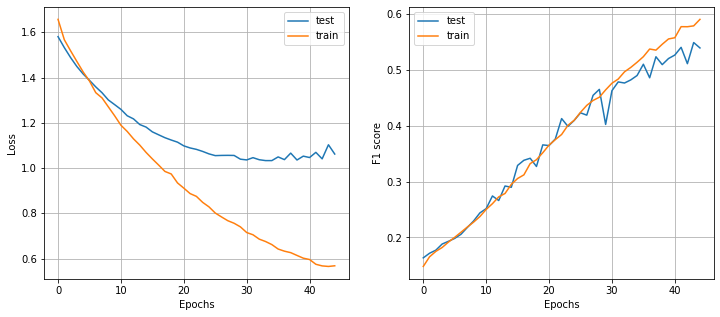

100%|██████████| 45/45 [03:51<00:00,  5.14s/it]


In [5]:
rnn = RNN_doc2idxs(
    voc_size=37928, # from Pre-processing.ipynb
    embedding_size=256,
    padding_idx=0, # from Pre-processing.ipynb
    hidden_state_size=256,
    n_rec_layers=2,
    output_size=5
).to(device)

optimizer = Adam(rnn.parameters(), lr=1e-4)

train_with_int_input(rnn,
      optimizer=optimizer,
      criterion=nn.NLLLoss(weight=weights),
      train_loader=DataLoader(train_df, batch_size=256, shuffle=True),
      test_loader=DataLoader(test_df, batch_size=256, shuffle=False),
      epochs=45,
      saving_path=saving_path,
      scheduler=StepLR(optimizer, step_size=1, gamma=0.99))

In [20]:
rnn = RNN_doc2idxs(
    voc_size=37928, # from Pre-processing.ipynb
    embedding_size=256,
    padding_idx=0, # from Pre-processing.ipynb
    hidden_state_size=256,
    n_rec_layers=2,
    output_size=5
).to(device)
rnn.load_state_dict(torch.load(saving_path, map_location=device))
rnn.eval()

with torch.no_grad():
    y_pred = torch.argmax(rnn(torch.from_numpy(X_test).to(device)), dim=1).cpu().numpy() - 2
    print(y_pred)
    print(classification_report(y_test, y_pred))

[ 0  0  1 ... -1  0  0]
              precision    recall  f1-score   support

          -2       0.38      0.74      0.51       473
          -1       0.52      0.59      0.55      2746
           0       0.72      0.52      0.61      4174
           1       0.49      0.69      0.57       522
           2       0.44      0.78      0.57       105

    accuracy                           0.57      8020
   macro avg       0.51      0.67      0.56      8020
weighted avg       0.61      0.57      0.58      8020



### Doc2matrix as input

In [7]:
if torch.cuda.is_available(): # in my case it means running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    from pathlib import Path
    sources_path = Path("/content/drive/MyDrive")
    X_train = np.load(str(sources_path / 'Data/doc2matrix_X_train.npy'))
    y_train = np.load(str(sources_path / 'Data/y_train.npy'))
    X_test = np.load(str(sources_path / 'Data/doc2matrix_X_test.npy'))
    y_test = np.load(str(sources_path / 'Data/y_test.npy'))

    saving_path=str(sources_path / 'Trained_models/RNN_doc2matrix.pth')
else:
    X_train = np.load('Data/unbalanced/doc2matrix_X_train.npy')
    y_train = np.load('Data/unbalanced/y_train.npy')
    X_test = np.load('Data/unbalanced/doc2matrix_X_test.npy')
    y_test = np.load('Data/unbalanced/y_test.npy')

    saving_path='Trained_models/RNN_doc2matrix.pth'

train_df = CustomDataset(X_train, y_train)
test_df = CustomDataset(X_test, y_test)

weights=compute_weights_by_y_train(y_train)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
class RNN_doc2matrix(nn.Module):
    def __init__(self, hidden_state_size, n_rec_layers, input_size, output_size):
        super().__init__()
        self.n_rec_layers = n_rec_layers
        self.hidden_state_size = hidden_state_size

        self.rnn = nn.RNN(input_size, hidden_state_size, n_rec_layers, batch_first=True, dropout=0.2)
        self.bn = nn.BatchNorm1d(hidden_state_size)
        self.fc = nn.Linear(hidden_state_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        h_0 = torch.zeros(self.n_rec_layers, X.size(0), self.hidden_state_size).to(device)

        X, _ = self.rnn(X, h_0)
        X = X[:, -1:, :].flatten(start_dim=1)
        X = self.bn(X)
        X = torch.tanh(X)
        X = self.fc(X)
        X = self.logsoftmax(X)

        return X

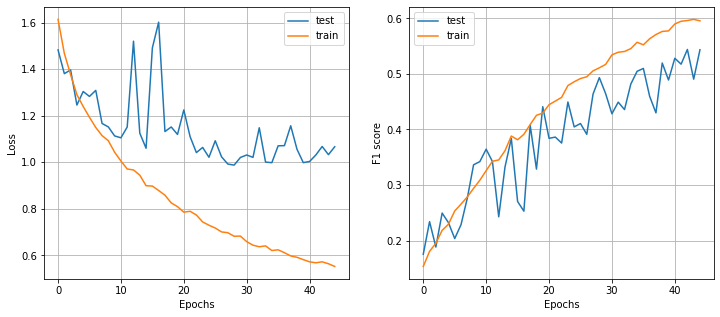

100%|██████████| 45/45 [12:01<00:00, 16.02s/it]


In [9]:
rnn = RNN_doc2matrix(
    hidden_state_size=512,
    n_rec_layers=2,
    input_size=300,
    output_size=5
).to(device)

optimizer = Adam(rnn.parameters(), lr=1e-4)

train(rnn,
      optimizer,
      criterion=nn.NLLLoss(weight=weights),
      train_loader=DataLoader(train_df, batch_size=256, shuffle=True),
      test_loader=DataLoader(test_df, batch_size=256, shuffle=False),
      epochs=45,
      saving_path=saving_path,
      scheduler=StepLR(optimizer, step_size=1, gamma=0.99))

In [10]:
# rnn = RNN_doc2matrix(
#     hidden_state_size=512,
#     n_rec_layers=2,
#     input_size=300,
#     output_size=5
# ).to(device)
# rnn.load_state_dict(torch.load(saving_path, map_location=device))
# rnn.eval()

with torch.no_grad():
    y_pred = torch.argmax(rnn(torch.from_numpy(X_test).to(device)), dim=1).cpu().numpy() - 2
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.35      0.76      0.48       473
          -1       0.52      0.69      0.60      2746
           0       0.80      0.45      0.57      4174
           1       0.46      0.73      0.56       522
           2       0.44      0.78      0.57       105

    accuracy                           0.57      8020
   macro avg       0.51      0.68      0.56      8020
weighted avg       0.65      0.57      0.58      8020

